## Script for analysis of results from ASTRA beam dynamics simulation

In [361]:
#import all the needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import yaml
import sys
import subprocess

## Definition of inputs
Define the name of the file and the run number, default settings are "Example" and "001". Also define the initial offsets and momenta for reference particles:


In [362]:
fileName = "Example"
fillNumber = "001"
xoffset = "2.0E-4" #m
yoffset =  "2.0E-4" #m
xmom = "1.0E+6" #eV
ymom = "1.0E+6" #eV

In [363]:
def update():
    #this function updates values for reference particles
    
    inputData = "  " + xoffset + "  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  5.0000E+08  0.0000E+00 -1.0000E-01   1   5"
    with open("test1.ini", "w") as file:
        file.write(inputData)

    inputData = "  0.0000E+00  " + yoffset + "  0.0000E+00  0.0000E+00  0.0000E+00  5.0000E+08  0.0000E+00 -1.0000E-01   1   5"
    with open("test2.ini", "w") as file:
        file.write(inputData)

    inputData = "  0.0000E+00  0.0000E+00  0.0000E+00 " + xmom + " 0.0000E+00  5.0000E+08  0.0000E+00 -1.0000E-01   1   5"
    with open("test3.ini", "w") as file:
        file.write(inputData)

    inputData = "  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00 " + ymom + " 5.0000E+08  0.0000E+00 -1.0000E-01   1   5"
    with open("test4.ini", "w") as file:
        file.write(inputData)
    
    return

In [364]:
update()

## Define several functions which will make life easier

In [365]:
def differLine(line):
    lineSplitted = line.split()
    
    return [float(num) for num in lineSplitted]    

In [366]:
def loadDataEmit(dir):
    #this function loads emit data,argument dir is X or Y or Z
    
    # z position [m], t [ns], X avr[mm], X rms [mm], X prime rms [mrad], epsilon x,norm [pi mrad mm], X times X prime avr[mrad] 
    data = []
    with open(fileName + "." + dir + "emit." + fillNumber,"r", encoding="utf-8") as fileX:
        for line in fileX:
            newLine = differLine(yaml.safe_load(line +"\n"))
            data.append(newLine)
            
    return data


In [367]:
def loadDataRef():
#open and load data about reference particle
#z [m], t [ns], pz [MeV/c], dE/dz [MeV/c], Larmor Angle [rad], x off [mm], y off [mm], px [eV/c], py [eV/c]
    
    data = []
    with open(fileName + ".ref." + fillNumber,"r") as file:
        for line in file:
            newLine = differLine(line)
            data.append(newLine)

    return data
    

In [368]:
def changeInputData(newDataName):

    try:
        # Open the file for reading
        with open(fileName + ".in", 'r') as file:
            lines = file.readlines()

        # Prepare the replacement string
        replacement = "Distribution=" + newDataName + "\n"

        # Iterate over the lines to find and replace the target line
        for i, line in enumerate(lines):
            if "Distribution=" in line:
                lines[i] = replacement
                break  # Assuming there's only one occurrence to replace

        # Write the modified lines back to the file
        with open(fileName + ".in", 'w') as file:
            file.writelines(lines)

        print(f"Replaced input data with '{replacement.strip()}'.")

    except FileNotFoundError:
        print("The file " + fileName + ".ini was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")


    return

In [369]:
def plotRefParticleXY(data, title):
#function to plot offsets in the X and Y direction of one reference particle
    z = []
    x = []
    y = []
    for line in data:
        z.append(line[0])
        x.append(line[5])
        y.append(line[6])

    plt.plot(z, x)
    plt.xlabel("z [m]")
    plt.ylabel("x [mm]")
    plt.title(title)

    plt.show()     

    plt.plot(z, y)
    plt.xlabel("z [m]")
    plt.ylabel("y [mm]")
    plt.title(title)

    plt.show()     

    
    return

In [370]:
def plotRefParticleMom(data,title):
#function that plots momentum of one reference particle along the Z axis 
    z = []
    pz = []
    px = []
    py = []
    for line in data:
        z.append(line[0])
        pz.append(line[2])
        px.append(line[7])
        py.append(line[8])

    plt.plot(z, px)
    plt.xlabel("z [m]")
    plt.ylabel("p_x [eV/c]")
    plt.title(title)

    plt.show()     

    plt.plot(z, py)
    plt.xlabel("z [m]")
    plt.ylabel("p_y [eV/c]")
    plt.title(title)
    
    plt.show()     

    plt.plot(z, pz)
    plt.xlabel("z [m]")
    plt.ylabel("p_z [MeV/c]")
    plt.title(title)


    plt.show()   
    
    
    return

In [371]:
def giveRefPlot(data, dir):
    #this function loads data from data and returns double array of variable along z axis
    var = 0
    if dir == "x":
        var = 5
    elif dir == "y":
        var = 6
    elif dir == "px":
        var = 7
    elif dir == "py":
        var = 8
    else:
        print("Incorrect second argument, Leaving...")
        return

    variable = []
    z = []
    for set in data:
        z.append(set[0])
        variable.append(set[var])
        
    func = []
    func.append(z)
    func.append(variable)

    return func

In [372]:
def plotVarAgainstZ(var,data0, data1, data2, data3, data4):
    #function which plots x offset along z axis
    x0 = giveRefPlot(data0, var)
    x1 = giveRefPlot(data1, var)
    x2 = giveRefPlot(data2, var)
    x3 = giveRefPlot(data3, var)
    x4 = giveRefPlot(data4, var)

    plt.plot(x0[0], x0[1], label='0 offset, 0 angle', color='blue')
    plt.plot(x1[0], x1[1], label='x offset, 0 angle', color='red')
    plt.plot(x2[0], x2[1], label='y offset, 0 angle', color='green')
    plt.plot(x3[0], x3[1], label='0 offset, x angle', color='purple')
    plt.plot(x4[0], x4[1], label='0 offset, y angle', color='yellow')

    plt.xlabel("z [m]")
    if var == "x" or var == "y":
        plt.ylabel(var + " [mm]")
    elif var == "pz":
        plt.ylabel(var + " [MeV/c]")        
    else:
        plt.ylabel(var + " [eV/c]")

    plt.legend()

    plt.show()
    
    return

## 0. run
run 0 is only one particle with 0 offset in the transverse plane as well as in the longitudinal direction. The particle should not move in the transverse direction.

In [373]:
dataName = "test0"
changeInputData(dataName + ".ini")

subprocess.run("source /opt/intel/oneapi/setvars.sh && ./Astra " + fileName, shell=True,check=True,executable='/bin/bash' )

data0 = loadDataRef()

#plotRefParticleXY(data0, "0 offset, 0 angle")
#plotRefParticleMom(data0, "0 offset, 0 angle")

Replaced input data with 'Distribution=test0.ini'.
 
:: initializing oneAPI environment ...
   bash: BASH_VERSION = 5.1.16(1)-release
   args: Using "$@" for setvars.sh arguments: 
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: ipp -- latest
:: ippcp -- latest
:: mkl -- latest
:: mpi -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 
 --------------------------------------------------------------------------

               Astra - A space charge tracking algorithm 
                             Version 4.0              
                         DESY,  Hamburg 2022          
                         22. 8.2024  15:49

     Parameter file is:  Example.in                                        
     Example of ASTRA users manual                                                   

 Initialize element settings:
     negl

## 1. run
first real run- particle has initial offset in the x direction.

In [374]:
#first run: particle with x offset (3 mm) and 0 angle
dataName = "test1"
changeInputData(dataName + ".ini")

subprocess.run("source /opt/intel/oneapi/setvars.sh && ./Astra " + fileName, shell=True,check=True,executable='/bin/bash' )

data1 = loadDataRef()
#plotRefParticleXY(data1, "x offset (3 mm), 0 angle")
#plotRefParticleMom(data1, "x offset (3 mm), 0 angle")

Replaced input data with 'Distribution=test1.ini'.
 
:: initializing oneAPI environment ...
   bash: BASH_VERSION = 5.1.16(1)-release
   args: Using "$@" for setvars.sh arguments: 
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: ipp -- latest
:: ippcp -- latest
:: mkl -- latest
:: mpi -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 
 --------------------------------------------------------------------------

               Astra - A space charge tracking algorithm 
                             Version 4.0              
                         DESY,  Hamburg 2022          
                         22. 8.2024  15:49

     Parameter file is:  Example.in                                        
     Example of ASTRA users manual                                                   

 Initialize element settings:
     negl

## 2. run
offset in the y direction, 0 angle.

In [375]:
dataName = "test2"
changeInputData(dataName + ".ini")

subprocess.run("source /opt/intel/oneapi/setvars.sh && ./Astra " + fileName, shell=True,check=True,executable='/bin/bash' )

data2 = loadDataRef()

#plotRefParticleXY(data2, "y offset (3 mm), 0 angle")
#plotRefParticleMom(data2, "y offset (3 mm), 0 angle")

Replaced input data with 'Distribution=test2.ini'.
 
:: initializing oneAPI environment ...
   bash: BASH_VERSION = 5.1.16(1)-release
   args: Using "$@" for setvars.sh arguments: 
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: ipp -- latest
:: ippcp -- latest
:: mkl -- latest
:: mpi -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 
 --------------------------------------------------------------------------

               Astra - A space charge tracking algorithm 
                             Version 4.0              
                         DESY,  Hamburg 2022          
                         22. 8.2024  15:49

     Parameter file is:  Example.in                                        
     Example of ASTRA users manual                                                   

 Initialize element settings:
     negl

## 3. run
zero offset in x and y direction, angle in the x direction

In [376]:
dataName = "test3"
changeInputData(dataName + ".ini")

subprocess.run("source /opt/intel/oneapi/setvars.sh && ./Astra " + fileName, shell=True,check=True,executable='/bin/bash' )

data3 = loadDataRef()

#plotRefParticleXY(data3, "0 offset, x angle ")
#plotRefParticleMom(data3, "0 offset, x angle")

Replaced input data with 'Distribution=test3.ini'.
 
:: initializing oneAPI environment ...
   bash: BASH_VERSION = 5.1.16(1)-release
   args: Using "$@" for setvars.sh arguments: 
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: ipp -- latest
:: ippcp -- latest
:: mkl -- latest
:: mpi -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 
 --------------------------------------------------------------------------

               Astra - A space charge tracking algorithm 
                             Version 4.0              
                         DESY,  Hamburg 2022          
                         22. 8.2024  15:49

     Parameter file is:  Example.in                                        
     Example of ASTRA users manual                                                   

 Initialize element settings:
     negl

## 4. run
zero offset, angle in the y direction

In [377]:
dataName = "test4"
changeInputData(dataName + ".ini")

subprocess.run("source /opt/intel/oneapi/setvars.sh && ./Astra " + fileName, shell=True,check=True,executable='/bin/bash' )

data4 = loadDataRef()
#plotRefParticleXY(data3, "0 offset, x angle ")
#plotRefParticleMom(data3, "0 offset, x angle")

Replaced input data with 'Distribution=test4.ini'.
 
:: initializing oneAPI environment ...
   bash: BASH_VERSION = 5.1.16(1)-release
   args: Using "$@" for setvars.sh arguments: 
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: ipp -- latest
:: ippcp -- latest
:: mkl -- latest
:: mpi -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 
 --------------------------------------------------------------------------

               Astra - A space charge tracking algorithm 
                             Version 4.0              
                         DESY,  Hamburg 2022          
                         22. 8.2024  15:49

     Parameter file is:  Example.in                                        
     Example of ASTRA users manual                                                   

 Initialize element settings:
     negl

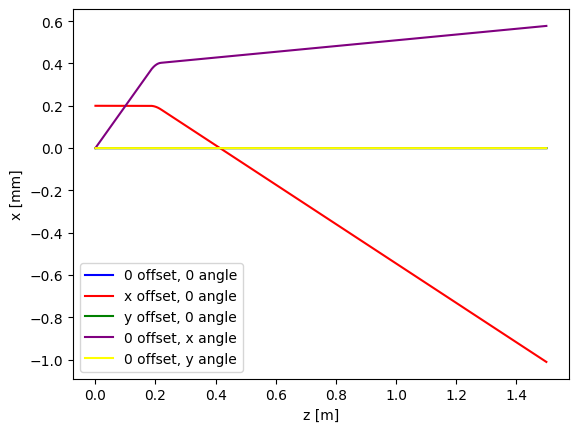

In [378]:
plotVarAgainstZ("x", data0, data1, data2, data3, data4)

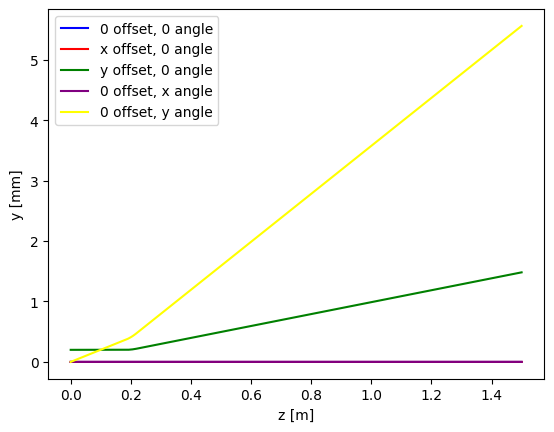

In [379]:
plotVarAgainstZ("y", data0, data1, data2, data3, data4)

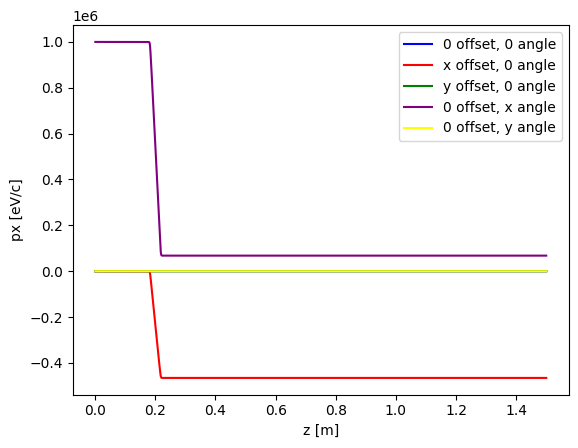

In [380]:
plotVarAgainstZ("px", data0, data1, data2, data3, data4)

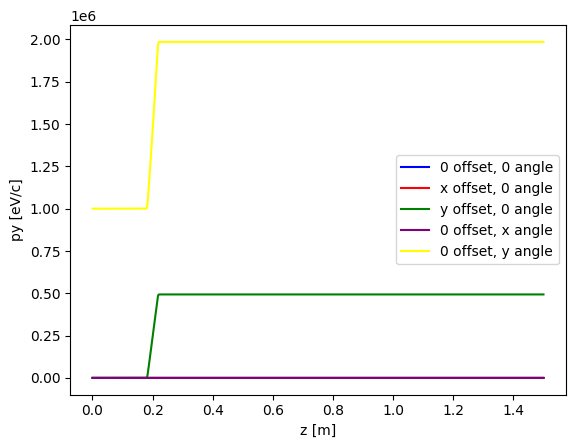

In [381]:
plotVarAgainstZ("py", data0, data1, data2, data3, data4)